## Transfer Learning with TensorFlow Part 3: Scaling up

In [1]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

In [2]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [3]:
# get 10% of Food101 data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
# unzip_data("101_food_classes_10_percent.zip")

In [4]:
# set up the train and test dir
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [5]:
# files in the directories
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tuna_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 direc

In [6]:
# set up the inputs
IMG_SIZE=(224, 224)

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data_all_10_percent = image_dataset_from_directory(directory=train_dir, 
                                                         label_mode="categorical",
                                                         image_size=IMG_SIZE)
test_data = image_dataset_from_directory(directory=test_dir,
                                        label_mode="categorical",
                                        image_size=IMG_SIZE,
                                        shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.


2022-01-25 14:37:34.074418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 14:37:34.082064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 14:37:34.082325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 14:37:34.082945: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 25250 files belonging to 101 classes.


In [7]:
train_data_all_10_percent.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [8]:
len(train_data_all_10_percent.class_names)

101

In [9]:
# create the modelcheckpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/checkpoint.ckpt"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                      verbose=1, 
                                      save_best_only=True, 
                                      save_weights_only=True, 
                                      monitor="val_accuracy")

In [10]:
# create the data augmetation layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomHeight, RandomWidth, RandomZoom, RandomRotation, Rescaling

augmentation_layer = Sequential([
    RandomFlip("horizontal"),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2),
    RandomRotation(0.2)
    # Rescaling(1/255.) since efficientnet does have Rescaling build in base layer, therefore it is not need. Other model might this
], name="augmentation_layer")

In [11]:
# set up the base EfficientNetB0 freeze the layers
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

In [12]:
# stack the layers
input_shape = (224, 224, 3)
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model

inputs = Input(shape=input_shape, name="input_layer")
x = augmentation_layer(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
outputs = Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = Model(inputs, outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [14]:
# compile the model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=["accuracy"])

In [15]:
# fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                          epochs=5,
                                          validation_data=test_data,
                                          validation_steps=int(0.15 * len(test_data)),
                                          callbacks=[checkpoint_callback])

Epoch 1/5


2022-01-25 14:37:42.912700: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-01-25 14:37:43.501849: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-25 14:37:43.502835: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


237/237 [==============================] - ETA: 0s - loss: 3.4715 - accuracy: 0.2474
Epoch 00001: val_accuracy improved from -inf to 0.43591, saving model to 101_classes_10_percent_data_model_checkpoint/checkpoint.ckpt
237/237 [==============================] - 77s 305ms/step - loss: 3.4715 - accuracy: 0.2474 - val_loss: 2.4612 - val_accuracy: 0.4359
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.3747 - accuracy: 0.4499
Epoch 00002: val_accuracy improved from 0.43591 to 0.50397, saving model to 101_classes_10_percent_data_model_checkpoint/checkpoint.ckpt
237/237 [==============================] - 55s 231ms/step - loss: 2.3747 - accuracy: 0.4499 - val_loss: 2.0315 - val_accuracy: 0.5040
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0028 - accuracy: 0.5224
Epoch 00003: val_accuracy improved from 0.50397 to 0.52331, saving model to 101_classes_10_percent_data_model_checkpoint/checkpoint.ckpt
237/237 [==============================] - 52s 21

In [16]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 55s 69ms/step - loss: 1.7273 - accuracy: 0.5493


[1.7272965908050537, 0.5493069291114807]

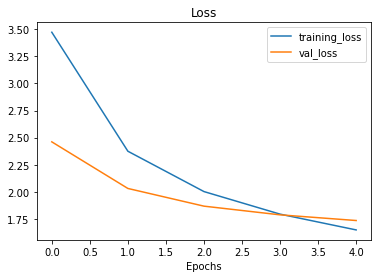

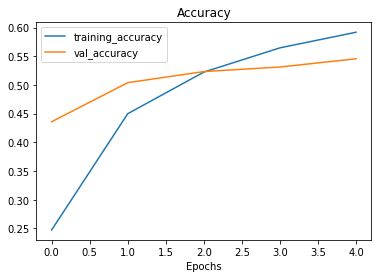

In [17]:
plot_loss_curves(history_all_classes_10_percent)

## Fine Tune the model

In [18]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
augmentation_layer True
efficientnetb0 False
global_average_pooling_2d True
output_layer True


In [19]:
for i, layer in enumerate(model.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [20]:
# unfreeze the last five layer of efficientnetb0
for layer in model.layers[2].layers[-5:]:
    print(layer, layer.trainable)

for layer in model.layers[2].layers[-5:]:
    layer.trainable = True

print("\n")

for layer in model.layers[2].layers[-5:]:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7ff54001c700> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff540038160> False
<keras.layers.convolutional.Conv2D object at 0x7ff5424745e0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff54003c250> False
<keras.layers.core.activation.Activation object at 0x7ff54003ff70> False


<keras.layers.convolutional.Conv2D object at 0x7ff54001c700> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff540038160> True
<keras.layers.convolutional.Conv2D object at 0x7ff5424745e0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff54003c250> True
<keras.layers.core.activation.Activation object at 0x7ff54003ff70> True


In [21]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 43s 181ms/step - loss: 1.5321 - accuracy: 0.6222 - val_loss: 1.7030 - val_accuracy: 0.5498
Epoch 6/10
237/237 [==============================] - 42s 175ms/step - loss: 1.4171 - accuracy: 0.6463 - val_loss: 1.6805 - val_accuracy: 0.5524
Epoch 7/10
237/237 [==============================] - 38s 162ms/step - loss: 1.3248 - accuracy: 0.6733 - val_loss: 1.6545 - val_accuracy: 0.5585
Epoch 8/10
237/237 [==============================] - 37s 156ms/step - loss: 1.2590 - accuracy: 0.6878 - val_loss: 1.6468 - val_accuracy: 0.5628
Epoch 9/10
237/237 [==============================] - 36s 153ms/step - loss: 1.1882 - accuracy: 0.7050 - val_loss: 1.6526 - val_accuracy: 0.5620
Epoch 10/10
237/237 [==============================] - 35s 146ms/step - loss: 1.1431 - accuracy: 0.7159 - val_loss: 1.6391 - val_accuracy: 0.5644


In [22]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 54s 69ms/step - loss: 1.6341 - accuracy: 0.5651


[1.6340830326080322, 0.5651485323905945]

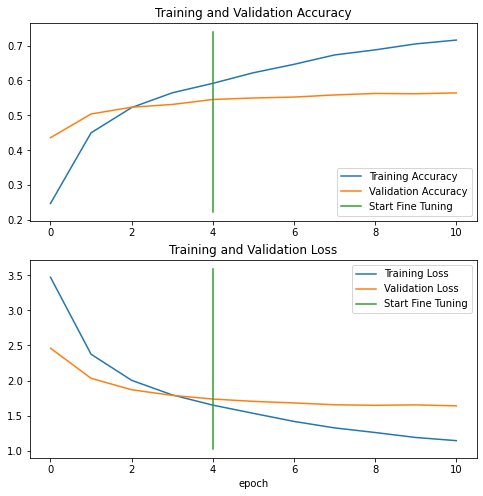

In [23]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Making predictions with trained model

In [24]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 61s 76ms/step


In [25]:
# prediction length and shape
len(preds_probs), preds_probs.shape

(25250, (25250, 101))

In [29]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([1.1903843e-04, 2.7652422e-04, 8.8188890e-06, 1.9306288e-05,
        7.6416058e-05, 3.3543300e-05, 3.1781381e-06, 1.8873562e-03,
        9.9413679e-05, 2.5095725e-03, 3.8766160e-05, 7.3127123e-04,
        1.2199615e-05, 9.7472803e-05, 2.7282944e-05, 5.2139658e-04,
        5.0389623e-05, 1.7288153e-06, 1.0806093e-01, 3.2063443e-03,
        1.8533258e-03, 1.1569458e-05, 5.2293486e-05, 9.1186572e-05,
        6.6357679e-05, 1.9664150e-04, 8.4869815e-03, 3.1636820e-05,
        1.1360128e-05, 1.0113702e-05, 7.4475684e-06, 1.7166595e-04,
        4.1676499e-03, 4.7700290e-05, 3.9045062e-05, 1.1399371e-05,
        4.4569289e-04, 7.9642242e-04, 1.9303260e-03, 6.5909730e-06,
        1.0114325e-04, 7.7008859e-05, 2.1165382e-05, 8.0904961e-01,
        5.1544355e-03, 6.9221828e-06, 2.0791964e-05, 3.5214382e-03,
        2.0293273e-04, 2.4953394e-03, 8.8865648e-04, 1.0709816e-03,
        5.1760850e-03, 3.5816099e-04, 1.5605728e-03, 3.3245832e-04,
        9.0957503e-04, 2.5475613e-04, 6.0180475e

In [30]:
preds_probs[0].argmax()

43

In [31]:
train_data_all_10_percent.class_names[preds_probs[0].argmax()]

'fried_calamari'

In [36]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([43, 12, 14, 11, 66, 80, 62, 79, 14, 45])

In [37]:
# How many pred classes do we have?
len(pred_classes)

25250

In [38]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10 

[58, 9, 1, 64, 95, 2, 83, 32, 13, 94]

In [39]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.010574257425742575